$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Wm}{\mathbf{W}}
 \newcommand{\Ym}{\mathbf{Y}}
 \newcommand{\I}{\mathbf{I}}
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
$

# Autoencoders

Auto-encoders are the framework for learning features with neural network bottelneck structure. The model redudes the number of features in an unsupervised way. 
Previously, encoding/decoding or dimensionality reduction was investigated in variouus ways.
Autoencoders, however, simply copy the input to their outputs for the codings. 

![](http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/linear_AE.png)


In [27]:
# preparation

import tensorflow as tf
# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import IPython.display as ipd  # for display and clear_output

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Linear Autoencoder

With the linear activation function and the cost function is the mean squared error (MSE), we can build a linear autoencoder as follows.

In [11]:
# Prepare data

import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

# normalize it
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])


In [13]:
reset_graph()

n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
n_iterations = 1000
codings = hidden  ### HERE: hidden unit outputs are encodings!

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

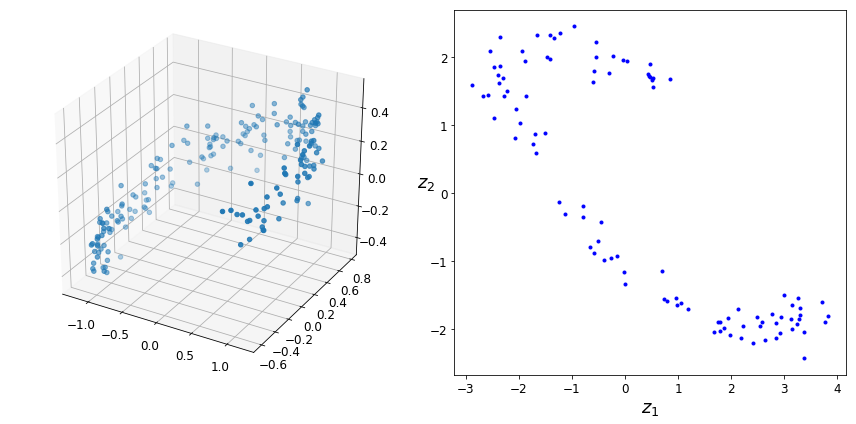

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:,0], data[:, 1], data[:, 2])

fig.add_subplot(122)
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)

plt.tight_layout()

# MNIST Data for Pactice

In [1]:
# loading data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [6]:
mnist.train.images[0].shape

(784,)

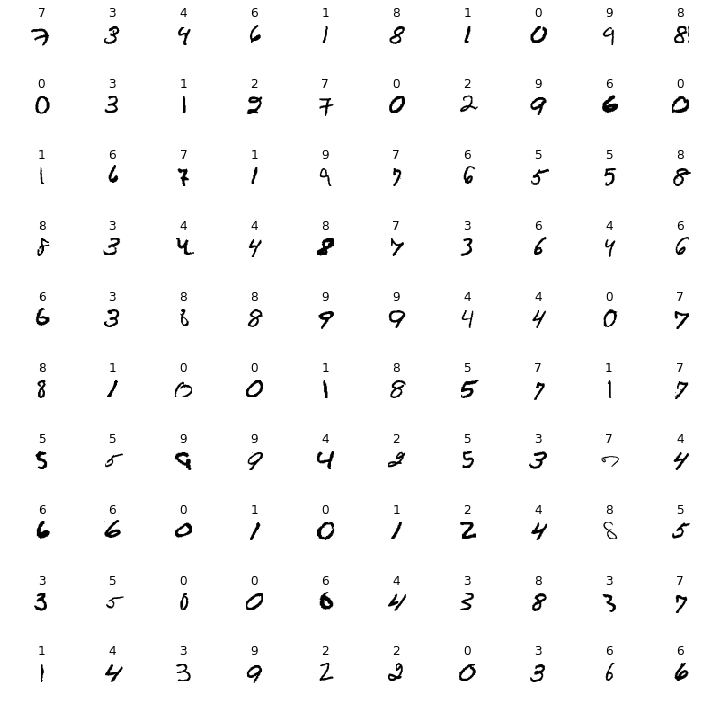

In [10]:
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(-mnist.train.images[i].reshape(28, 28), interpolation='nearest', cmap='gray')
    plt.axis('off')
    plt.title(mnist.train.labels[i])
plt.tight_layout()

# Stacked Autoencoder 

To handle complex data encodings, we can simply apply nonlinear activation. Also, we can make it *deep* as we practice deep learning for more complex codings. As our text warned, however, we need to be careful when building too deep so that we loose generalization of our stacked autoencoder. 

Following figure shows the sysmetrically built autoencoder for MNIST data set. 

![](http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/SAE.png)


In [66]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

In [67]:
# Training the network! 

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # not shown
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown
        saver.save(sess, "./my_model_all_layers.ckpt")                  # not shown

09% Train MSE: 0.0269275
1 Train MSE: 0.0148281
2 Train MSE: 0.0114849
3 Train MSE: 0.0109921
4 Train MSE: 0.00990862


During training, we stored the autoencoder. By using the encoder, the upper half, we can encode and display for comparison.   

In [68]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2, shape=(28, 28)):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(15, 6))
    sq = np.sqrt(n_test_digits)
    for digit_index in range(n_test_digits):
        plt.subplot(sq, 2*sq, digit_index * 2 + 1)
        plt.imshow(X_test[digit_index].reshape(shape), cmap="Greys", interpolation="nearest")
        plt.axis("off")
        plt.subplot(sq, 2*sq, digit_index * 2 + 2)
        plt.imshow(outputs_val[digit_index].reshape(shape), cmap="Greys", interpolation="nearest")
        plt.axis("off")

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


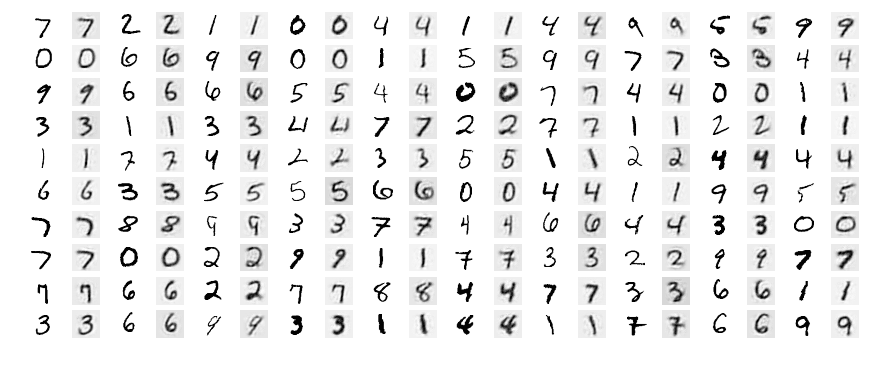

In [36]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt", 100)


In [94]:
def plot_codings2d(codings, model_path=None, filter=None, n_digits=500):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        test_codings = codings.eval(feed_dict={X: mnist.test.images})

    plt.figure(figsize=(10,10))
    for i, txt in enumerate(mnist.test.labels[:n_digits]):
        if filter is None or txt in filter:
            plt.annotate(txt, (test_codings[i, 0], test_codings[i, 1]), color=''.join(['C', str(txt)]))

INFO:tensorflow:Restoring parameters from my_model_all_layers.ckpt


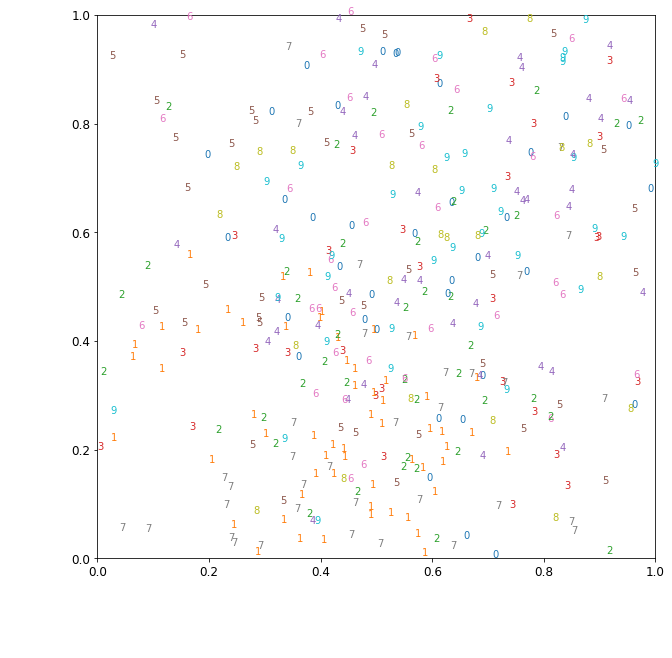

In [95]:
plot_codings2d(hidden2, "my_model_all_layers.ckpt")

INFO:tensorflow:Restoring parameters from my_model_all_layers.ckpt


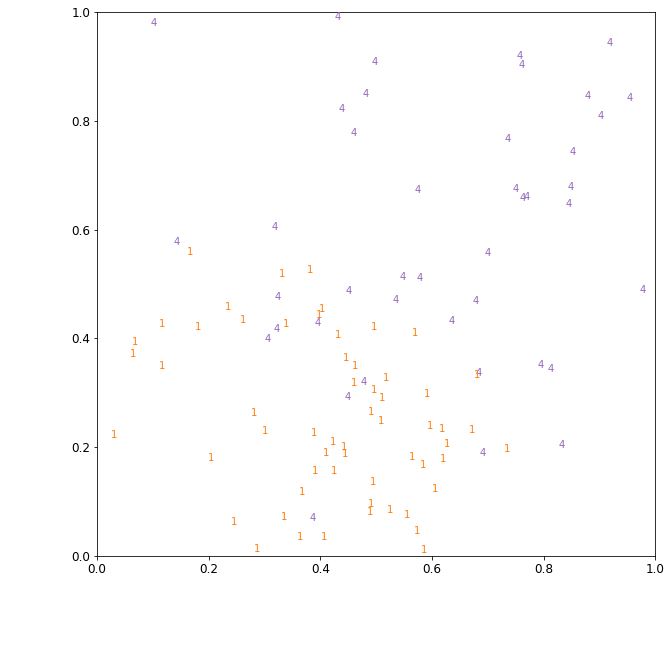

In [102]:
plot_codings2d(hidden2, "my_model_all_layers.ckpt", [1, 4])

# Tying Weights

For the stacked autoencoder, we used two $28 \times 28$ input and output units, two 300 hidden units and 150 bottleneck units. In total, we are using 2,318 units for computation. For the symmetric networks, we can use the same weights for symmetric weights. Yes, we can *tie the weights* with simple transpose operation. 

When the first unit weight matrix is $\Wm_1$, then the output unit weights is simply $\Wm_1^\top$, and so on.  

In [37]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

#### Since it is easier without using dense net, 
#### let us build networks manually.
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [38]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.0150667
1 Train MSE: 0.0164884
2 Train MSE: 0.0173757
3 Train MSE: 0.0168781
4 Train MSE: 0.0155875


Let us check if the reconstructed images are OK. 

INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


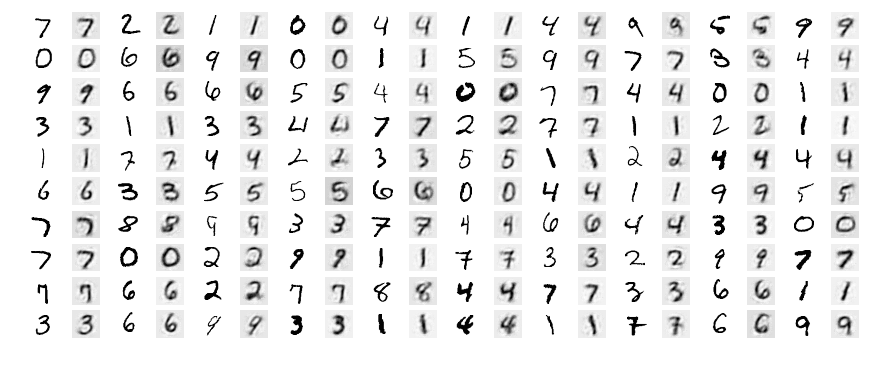

In [40]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt", 100)

# Learning Faster by Decomposing Deep Networks

When the stacked autoencoders or deep networks have many layers, it is often useful or fast to train if you train a shallow layer at a time. The figure in our text depicts this process. 

![](http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/train_AE.png)


In [41]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005,
                      activation=tf.nn.elu, seed=42):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            activation=activation,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=None, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [43]:
print("First, trainig the phase 1, outer shells...")
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150)

print("\nNow, training inner layers, phase 2....")
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

First, trainig the phase 1, outer shells...
0 Train MSE: 0.0174996
1 Train MSE: 0.0200729
2 Train MSE: 0.0189012
3 Train MSE: 0.0191032

Now, training inner layers, phase 2....
0 Train MSE: 0.00425563
1 Train MSE: 0.00422491
2 Train MSE: 0.00466292
3 Train MSE: 0.00496209


We have trained weights and biases in variables now. Using them to construct the stacked autoencoder. 

In [44]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

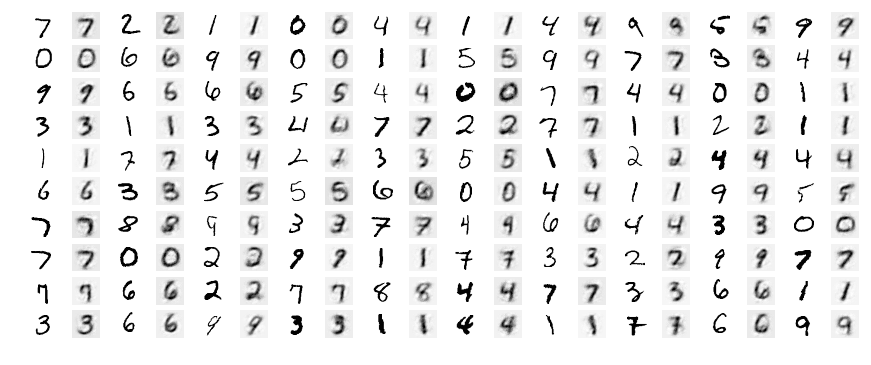

In [45]:
show_reconstructed_digits(X, outputs, n_test_digits=100)

# What is it capturing from input? 

By looking at the weights, we can observe the activations of a certain part of images that represents a certain label. 


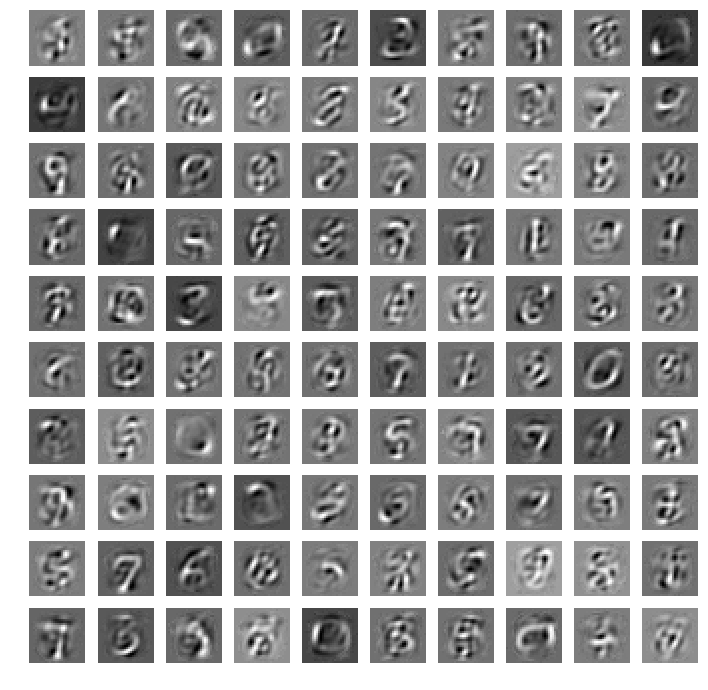

In [52]:
plt.figure(figsize=(12, 12))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(W1.T[i].reshape((28, 28)), cmap="gray")
    plt.axis('off')

# Building a Classifier with Encoder

Now, we can reuse the upper part of the autoencoder, the encoder, to another deep networks for nonlinear classification or logistic regression. 
For this, we do not need to relearn from scratch. 

![](http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/AE_classify.png)
